In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import researchpy as rp
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.simplefilter(action='ignore', category=FutureWarning)


## Data Cleaning and Preprocessing


In [2]:
# read in excel data into pandas dataframe
# replace the filename with an xlsx file containing survey data
df = pd.read_excel("CSInternships_Data.xlsx","Regression_Data")

In [3]:
# remove extraneous column headers
df=df.drop(df.index[[0,1]])

In [4]:
columns = ['id','hs_courses','enrollment_status','year','gpa','employment_status',
        'income','age','gender','race','internship',
          'moratorium_1', 'moratorium_2', 'moratorium_3', 'moratorium_4', 'moratorium_5', 'moratorium_6',
           'diffusion_1', 'diffusion_2', 'diffusion_3', 'diffusion_4', 'diffusion_5', 'diffusion_6',
           'achieved_1', 'achieved_2', 'achieved_3', 'achieved_4', 'achieved_5', 'achieved_6',
           'foreclosure_1', 'foreclosure_2', 'foreclosure_3', 'foreclosure_4', 'foreclosure_5', 'foreclosure_6',
           'in_1','in_2','in_3','in_4','in_5','in_6','in_7','in_8','in_9','in_10','in_11','in_12','in_13','in_14']


df=df[columns]

In [5]:
# encode internship (dependent variable)
df.loc[df['internship'] == "I have not interned yet", 'internship'] = 0
df.loc[df['internship'] != 0, 'internship'] = 1
df['internship'] = df['internship'].astype(str).astype(int)

# encode CS courses
df.loc[df['hs_courses'] == "No", 'hs_courses'] = 0
df.loc[df['hs_courses'] != 0, 'hs_courses'] = 1
df['hs_courses'] = df['hs_courses'].astype(str).astype(int)

# encode employment status
df.loc[df['employment_status'] == "Not working", 'employment_status'] = 0
df.loc[df['employment_status'] != 0, 'employment_status'] = 1
df['employment_status'] = df['employment_status'].astype(str).astype(int)

# binary encode enrollment status
enrollment_mapper = {'Part-time Undergraduate Student':0,  'Full-time Undergraduate Student':1}
df['enrollment_status'] = df['enrollment_status'].replace(enrollment_mapper)

# binary encode gender
gender_mapper = {'Male':0,  'Female':1}
df['gender'] = df['gender'].replace(gender_mapper)

# ordinal encode year in school
year_scale_mapper = {'Freshman':1, 'Sophomore':2, 'Junior':3, 'Senior':4, 'Super Senior [Year 5 or Year 6]':5}
df['year'] = df['year'].replace(year_scale_mapper)

# ordinal encode income
income_scale_mapper = {"Less than $20,000":1, "$20,000 to $34,999":2, "$35,000 to $49,999":3, 
                       "$50,000 to $74,999":4, "$75,000 to $99,999":5, "$100,000 to $149,000":6, "Over $150,000":7}
df['income'] = df['income'].replace(income_scale_mapper)

# condense and encode race
race_condenser = {'White':'White/Asian', 'Asian':'White/Asian', 'Hispanic or Latinx':'Underrepresented', 
                  'African American':'Underrepresented', 'Others (Please specify)':'Underrepresented', 
                  'Native Hawaiian or Other Pacific Islander':'Underrepresented'}
df['race'] = df['race'].replace(race_condenser)

race_mapper = {'White/Asian':0,  'Underrepresented':1}
df['race'] = df['race'].replace(race_mapper)


In [6]:
# encode identity status
marcia_mapper = {'Strongly disagree':1, 'Disagree':2, 'Neither agree nor disagree':3, 'Agree':4, 'Strongly agree':5}


moratorium_questions = ['moratorium_1', 'moratorium_2', 'moratorium_3', 'moratorium_4', 'moratorium_5', 'moratorium_6']
diffusion_questions = ['diffusion_1', 'diffusion_2', 'diffusion_3', 'diffusion_4', 'diffusion_5', 'diffusion_6']
achievement_questions = ['achieved_1', 'achieved_2', 'achieved_3', 'achieved_4', 'achieved_5', 'achieved_6']
foreclosure_questions = ['foreclosure_1', 'foreclosure_2', 'foreclosure_3', 'foreclosure_4', 'foreclosure_5', 'foreclosure_6']

identity_questions = moratorium_questions + diffusion_questions + achievement_questions + foreclosure_questions

# # impute missing values for identity statuses
for q in identity_questions:
    df[q] = df[q].replace(marcia_mapper)

    

for q in moratorium_questions:
    median = df[q].median()
    df[q].fillna(value=median, inplace=True)

for q in diffusion_questions:
    median = df[q].median()
    df[q].fillna(value=median, inplace=True)
    

for q in achievement_questions:
    median = df[q].median()
    df[q].fillna(value=median, inplace=True)
    
for q in foreclosure_questions:
    median = df[q].median()
    df[q].fillna(value=median, inplace=True)

    
df['moratorium'] = df[moratorium_questions].sum(axis=1)
df['diffusion'] = df[diffusion_questions].sum(axis=1)
df['achievement'] = df[achievement_questions].sum(axis=1)
df['foreclosure'] = df[foreclosure_questions].sum(axis=1)



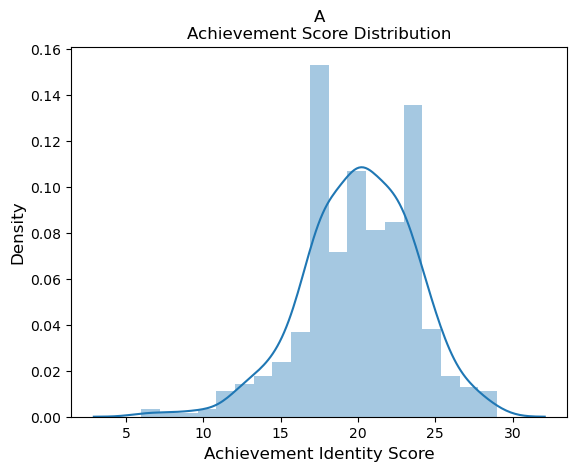

In [7]:
plot = sns.distplot(df['achievement'])
plot.set_xlabel("Achievement Identity Score", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("A\nAchievement Score Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("A.svg",format='svg', dpi=1200)

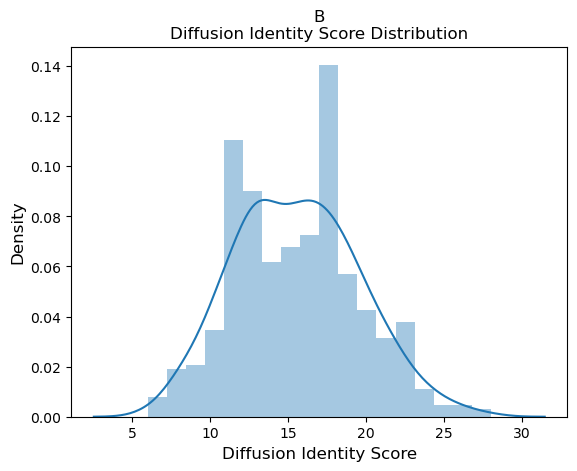

In [8]:
plot = sns.distplot(df['diffusion'])
plot.set_xlabel("Diffusion Identity Score", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("B\nDiffusion Identity Score Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("B.svg",format='svg', dpi=1200)

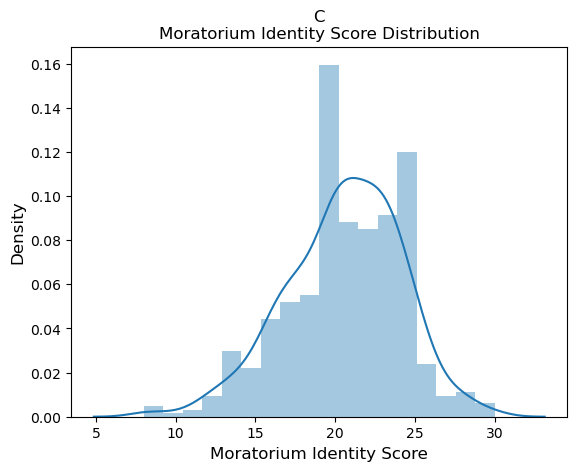

In [9]:
plot = sns.distplot(df['moratorium'])
plot.set_xlabel("Moratorium Identity Score", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("C\nMoratorium Identity Score Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("C.svg",format='svg', dpi=1200)

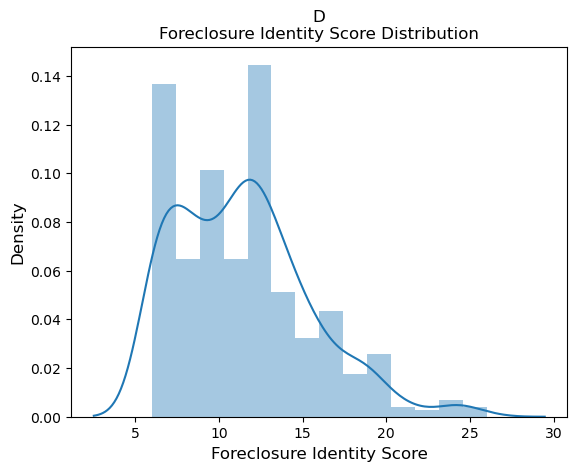

In [10]:
plot = sns.distplot(df['foreclosure'])
plot.set_xlabel("Foreclosure Identity Score", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("D\nForeclosure Identity Score Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("D.svg",format='svg', dpi=1200)

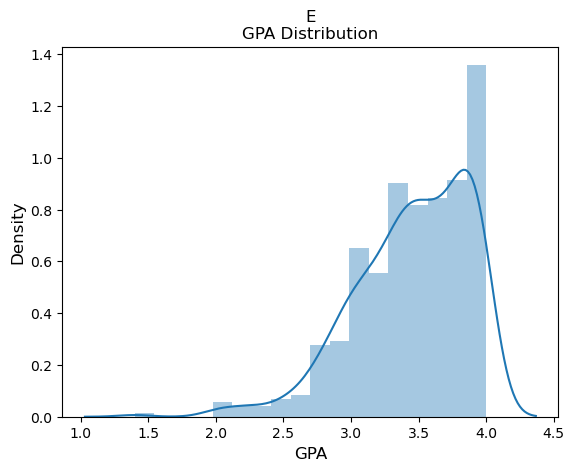

In [11]:
plot = sns.distplot(df['gpa'])
plot.set_xlabel("GPA", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("E\nGPA Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("E.svg",format='svg', dpi=1200)

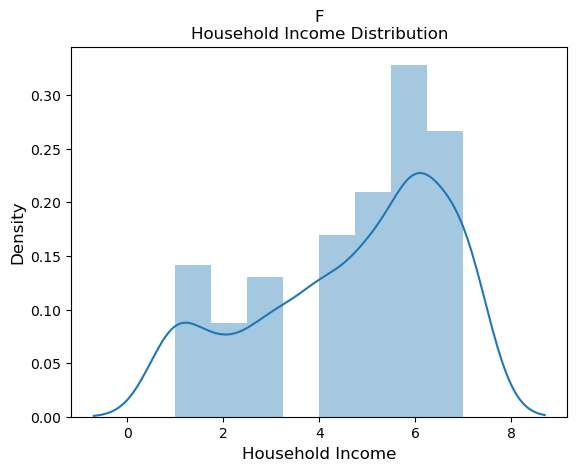

In [12]:
plot = sns.distplot(df['income'])
plot.set_xlabel("Household Income", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("F\nHousehold Income Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("F.svg",format='svg', dpi=1200)

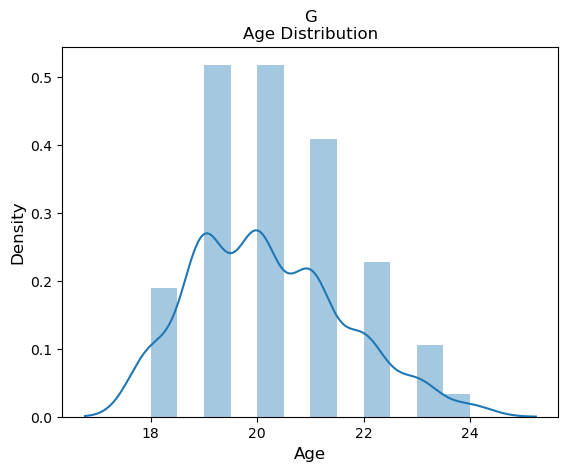

In [13]:
plot = sns.distplot(df['age'])
plot.set_xlabel("Age", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("G\nAge Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("G.svg",format='svg', dpi=1200)

In [14]:
# encode involvement 
involvement_mapper = {'Never':0, 'Once':1, '2-3 times':2, '4 or more times':3}

involvement_questions = ['in_1','in_2','in_3','in_4','in_5','in_6','in_7',
                         'in_8','in_9','in_10','in_11','in_12','in_13','in_14']

    
for q in involvement_questions:
    df[q] = df[q].replace(involvement_mapper)
    median = df[q].median()
    df[q].fillna(value=median, inplace=True)
    

df['involvement'] = df[involvement_questions].sum(axis=1)

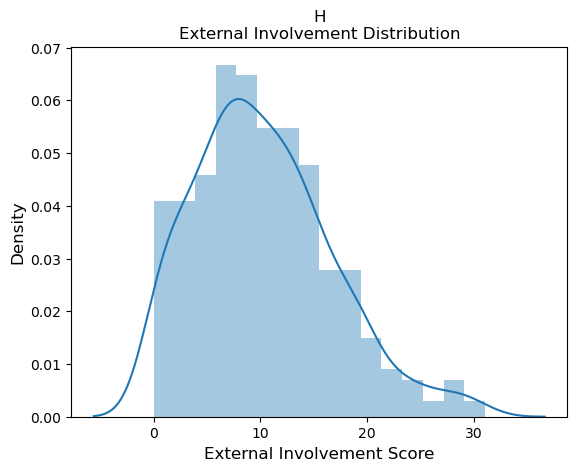

In [15]:
plot = sns.distplot(df['involvement'])
plot.set_xlabel("External Involvement Score", fontsize = 12)
plot.set_ylabel("Density", fontsize = 12)
plot.set_title("H\nExternal Involvement Distribution", fontsize=12)
plt.show()
fig = plot.get_figure()
fig.savefig("H.svg",format='svg', dpi=1200)

In [16]:
# impute missing values
mode_income=df['income'].mode()[0]
df['income'].fillna(value=mode_income, inplace=True)
print(mode_income)

median_gpa = df['gpa'].median()
df['gpa'].fillna(value=median_gpa, inplace=True)

# skewed distribution so we should use either median or mode
# for age, fill in average age for blanks
median_age = df['age'].median()
df['age'].fillna(value=median_age, inplace=True)

6.0


In [17]:
# check for any rows that still have na (this should be an empty dataframe if correct)
df1 = df[df.isna().any(axis=1)]
print(df1)

Empty DataFrame
Columns: [id, hs_courses, enrollment_status, year, gpa, employment_status, income, age, gender, race, internship, moratorium_1, moratorium_2, moratorium_3, moratorium_4, moratorium_5, moratorium_6, diffusion_1, diffusion_2, diffusion_3, diffusion_4, diffusion_5, diffusion_6, achieved_1, achieved_2, achieved_3, achieved_4, achieved_5, achieved_6, foreclosure_1, foreclosure_2, foreclosure_3, foreclosure_4, foreclosure_5, foreclosure_6, in_1, in_2, in_3, in_4, in_5, in_6, in_7, in_8, in_9, in_10, in_11, in_12, in_13, in_14, moratorium, diffusion, achievement, foreclosure, involvement]
Index: []

[0 rows x 54 columns]


In [18]:
df.to_csv('intern_data_cleaned.csv')

In [19]:
# drop id column (we aren't using this)
df = df.drop(['id'],1)

In [20]:
y = df['internship']
X = df[['hs_courses','employment_status','year','gpa','income','age','gender','race',
       'moratorium','diffusion','achievement','foreclosure','involvement']]

In [21]:
# split X into categorical and quantitative
X_quant = X[['gpa', 'age', 'achievement', 'diffusion', 'foreclosure', 'moratorium', 'involvement', 'income', 'year']].copy()
X_cat = X[['gender','race','hs_courses', 'employment_status',]].copy()

In [22]:
# export cleaned data to CSV
df.to_csv('cleaned_data.csv')

## Descriptive Statistics

In [23]:
summary_cont = rp.summary_cont(X_quant)
summary_cat = rp.summary_cat(X_cat)
summary_res = rp.summary_cat(y)
summary_cont.to_csv('summary_cont.csv')
summary_cat.to_csv('summary_cat.csv')
summary_res.to_csv('summary_res.csv')

In [24]:
summary_cont

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,gpa,518.0,3.4543,0.4178,0.0184,3.4182,3.4903
1,age,518.0,20.1911,1.3556,0.0596,20.0741,20.3081
2,achievement,518.0,20.0869,3.5841,0.1575,19.7775,20.3962
3,diffusion,518.0,15.5425,4.0223,0.1767,15.1953,15.8897
4,foreclosure,518.0,11.4363,4.0398,0.1775,11.0876,11.7850
5,moratorium,518.0,20.5328,3.6514,0.1604,20.2176,20.8480
6,involvement,518.0,10.2510,6.5110,0.2861,9.6889,10.8130
7,income,518.0,4.8185,1.8891,0.0830,4.6555,4.9816
8,year,518.0,2.5425,1.1985,0.0527,2.4390,2.6459


In [25]:
summary_cat

,Variable,Outcome,Count,Percent
0,gender,0,379,73.17
1,,1,139,26.83
2,race,0,374,72.20
3,,1,144,27.80
4,hs_courses,0,261,50.39
5,,1,257,49.61
6,employment_status,0,360,69.50
7,,1,158,30.50


In [26]:
summary_res

,Variable,Outcome,Count,Percent
0,internship,0,301,58.11
1,,1,217,41.89


In [27]:
df[["involvement"]].describe()

,involvement
count,518.000000
mean,10.250965
std,6.511019
min,0.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,31.000000


## Correlations and Independence Tests

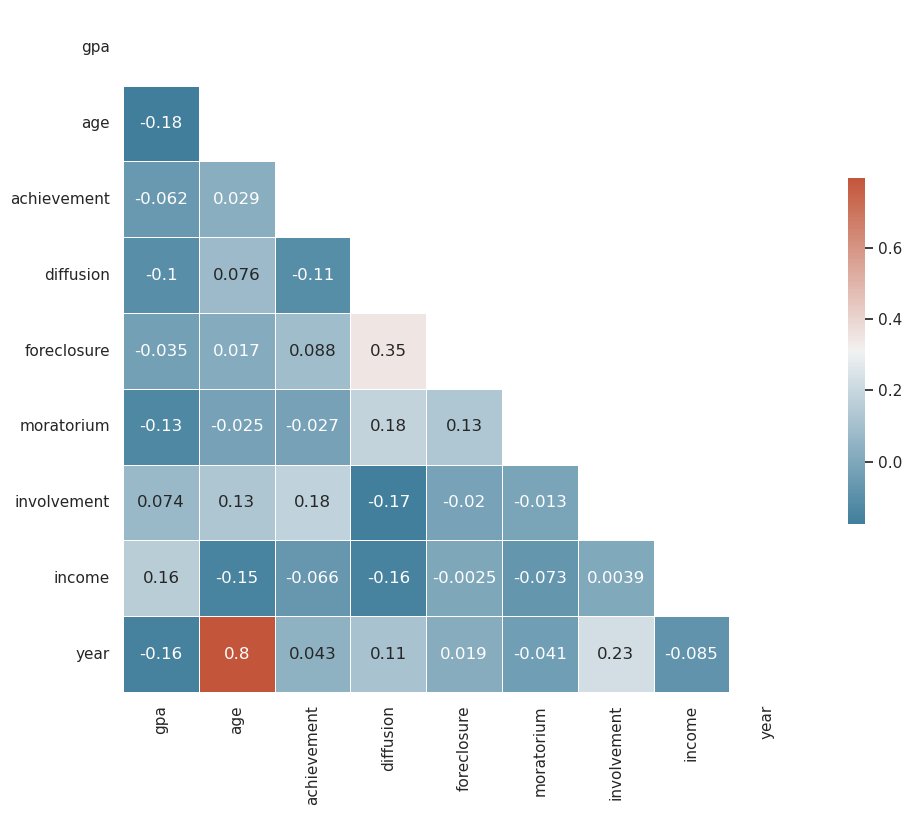

In [28]:
sns.set_theme(style="white")

corr = X_quant.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f,ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plot = sns.heatmap(corr, cmap=cmap, mask=mask, square=True,
           linewidths=0.5, cbar_kws={"shrink": .5}, annot=True)
fig = plot.get_figure()
fig.savefig("corr.svg",format='svg', dpi=1200)

In [29]:
# create a list of columns corresponding to categorical variables
catcols = ['gender', 'hs_courses', 'employment_status', 'race']

In [30]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://www.kaggle.com/code/mlwhiz/seaborn-visualizations-using-football-data/notebook
# https://github.com/shakedzy/dython
import scipy.stats as ss
from collections import Counter
import math 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted
    
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """

    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(10,5))#kwargs.get('figsize',None))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        heatmap = sns.heatmap(corr, annot=kwargs.get('annot',True), linewidths=.3, fmt=kwargs.get('fmt','.2f'), cmap=cmap)
        heatmap.set_title("Figure 2: Correlations", fontsize=12)
        sns
        plt.show()
        fig = heatmap.get_figure()
        fig.savefig("corr.svg",format='svg', dpi=1200)
    if return_results:
        return corr

In [31]:
X = X.rename(columns={"hs_courses": "HS CS Edu.", "employment_status": "Employment", "year": 'Year', "gpa": "GPA", 
                      "income":"Income", "gender":"Gender","race":"Race","moratorium":"Moratorium","diffusion":"Diffusion",
                      "achievement":"Achievement","foreclosure":"Foreclosure", "involvement":"Involvement", "age":"Age"})

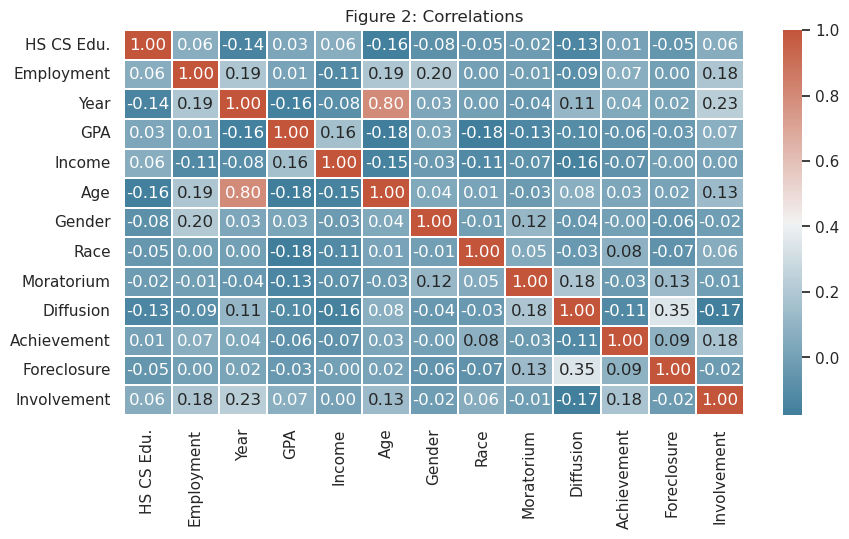

In [32]:
results = associations(X,return_results=True)

## Finalizing Preprocessing after Examining Correlations

In [33]:
#https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
from statsmodels.tools.tools import add_constant

Z = X.copy()
Z = add_constant(Z)

pd.Series([variance_inflation_factor(Z.values, i) 
               for i in range(Z.shape[1])], 
              index=Z.columns)


const          771.043551
HS CS Edu.       1.069631
Employment       1.150178
Year             2.976098
GPA              1.127316
Income           1.105469
Age              2.871147
Gender           1.081508
Race             1.063514
Moratorium       1.087937
Diffusion        1.314933
Achievement      1.077981
Foreclosure      1.183562
Involvement      1.187144
dtype: float64

In [34]:
# dropping age because correlation
X = X.drop(['Age'], 1)

In [35]:
# https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
from statsmodels.tools.tools import add_constant

X = add_constant(X)

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)


const          202.554143
HS CS Edu.       1.063038
Employment       1.144929
Year             1.190506
GPA              1.122981
Income           1.087900
Gender           1.081422
Race             1.063500
Moratorium       1.087937
Diffusion        1.308462
Achievement      1.077663
Foreclosure      1.182996
Involvement      1.176230
dtype: float64

## Logistic Regression Model

In [36]:
logit_model = sm.Logit(y, X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.539521
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             internship   No. Observations:                  518
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jan 2023   Pseudo R-squ.:                  0.2065
Time:                        19:54:53   Log-Likelihood:                -279.47
converged:                       True   LL-Null:                       -352.21
Covariance Type:            nonrobust   LLR p-value:                 4.685e-25
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.5317      1.603     -3.451      0.001      -8.674      -2.390
HS CS Edu.      0.2910    

In [37]:
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                   5%       95%  Odds Ratio
const        0.000171  0.091642    0.003959
HS CS Edu.   0.878934  2.036214    1.337796
Employment   0.703864  1.751757    1.110405
Year         1.457147  2.157657    1.773139
GPA          0.955085  2.892575    1.662124
Income       1.111455  1.400018    1.247421
Gender       0.467752  1.215888    0.754144
Race         0.733958  1.880299    1.174760
Moratorium   0.958071  1.072738    1.013785
Diffusion    0.886531  0.994809    0.939111
Achievement  0.949708  1.072311    1.009149
Foreclosure  0.938127  1.046267    0.990722
Involvement  1.092885  1.174661    1.133036


In [38]:
# example of 1 unit increase in GPA above: 3.0 GPA to 4.0 GPA
# use equation below to scale 1 unit increase in GPA to .1 (ex:  3.5 GPA to 3.6 GPA)
# https://online.stat.psu.edu/stat462/node/207/

np.exp(0.514*.10)
#1.0478495327807487e+00


1.0527439066375746